### Grading
The final score that you will receive for your programming assignment is generated in relation to the total points set in your programming assignment item—not the total point value in the nbgrader notebook.<br>
When calculating the final score shown to learners, the programming assignment takes the percentage of earned points vs. the total points provided by nbgrader and returns a score matching the equivalent percentage of the point value for the programming assignment.<br>
**DO NOT CHANGE VARIABLE OR METHOD SIGNATURES** The autograder will not work properly if your change the variable or method signatures. 

# Support Vector Machines 
***

In this assignment we'll explore the details of the Soft-Margin SVM and look at how the choice of tuning parameters  affects the learned models.  We'll also look at kernel SVMs for non-linearly separable and methods for choosing and visualizing good hyperparameters.   

**Note**: Below are some helper functions which are used throughout this notebook.  Execute these before continuing. Do not modify.

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
%matplotlib inline

def linear_plot(X, y, w=None, b=None):
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    
    # Plot data 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.scatter(X[:,0], X[:,1], color=colors, s=150, alpha=0.95, zorder=2)
    
    # Plot boundaries 
    lower_left = np.min([np.min(X[:,0]), np.min(X[:,1])])
    upper_right = np.max([np.max(X[:,0]), np.max(X[:,1])])
    gap = .1*(upper_right-lower_left)
    xplot = np.linspace(lower_left-gap, upper_right+gap, 20)
    if w is not None and b is not None: 
        ax.plot(xplot, (-b - w[0]*xplot)/w[1], color="gray", lw=2, zorder=1)
        ax.plot(xplot, ( 1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        ax.plot(xplot, (-1 -b - w[0]*xplot)/w[1], color="gray", lw=2, ls="--", zorder=1)
        
    
    ax.set_xlim([lower_left-gap, upper_right+gap])
    ax.set_ylim([lower_left-gap, upper_right+gap])
    
    ax.grid(alpha=0.25)
    
def part2data():
    
    np.random.seed(1239)
    
    X = np.zeros((22,2))
    X[0:10,0]  = 1.5*np.random.rand(10) 
    X[0:10,1]  = 1.5*np.random.rand(10)
    X[10:20,0] = 1.5*np.random.rand(10) +  1.75
    X[10:20,1] = 1.5*np.random.rand(10) +  1
    X[20,0] = 1.5
    X[20,1] = 2.25
    X[21,0] = 1.6
    X[21,1] = 0.25
    
    y = np.ones(22)
    y[10:20] = -1 
    y[20] = 1
    y[21] = -1
    
    return X, y

def part3data(N=100, seed=1235):
    
    np.random.seed(seed)
    
    X = np.random.uniform(-1,1,(N,2))
    y = np.array([1 if y-x > 0 else -1 for (x,y) in zip(X[:,0]**2 * np.sin(2*np.pi*X[:,0]), X[:,1])])
    X = X + np.random.normal(0,.1,(N,2))
    
    return X, y

def nonlinear_plot(X, y, clf=None): 
    
    mycolors = {"blue": "steelblue", "red": "#a76c6e", "green": "#6a9373"}
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]
    ax.scatter(X[:,0],X[:,1], marker='o', color=colors, s=100, alpha=0.5)
    
    ax.arrow(-1.25,0,2.5,0, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    ax.arrow(0,-1.25,0,2.5, head_length=0.05, head_width=0.05, fc="gray", ec="gray", lw=2, alpha=0.25)
    z = np.linspace(0.25,3.5,10)
    
    ax.set_xlim([-1.50,1.50])
    ax.set_ylim([-1.50,1.50])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.xticks([], fontsize=16)
    plt.yticks([], fontsize=16)
    

    if clf: 
        
        clf.fit(X,y)

        x_min = X[:, 0].min()+.00
        x_max = X[:, 0].max()-.00
        y_min = X[:, 1].min()+.00
        y_max = X[:, 1].max()-.00

        colors = [mycolors["red"] if yi==1 else mycolors["blue"] for yi in y]

        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(XX.shape)
        plt.contour(XX, YY, Z, colors=[mycolors["blue"], "gray", mycolors["red"]], linestyles=['--', '-', '--'],
                    levels=[-1.0, 0, 1.0], linewidths=[2,2,2], alpha=0.9)
    

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

from IPython.core.display import HTML
HTML("""
<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};
</style>
""")

### Part 1: SVM [20 pts]

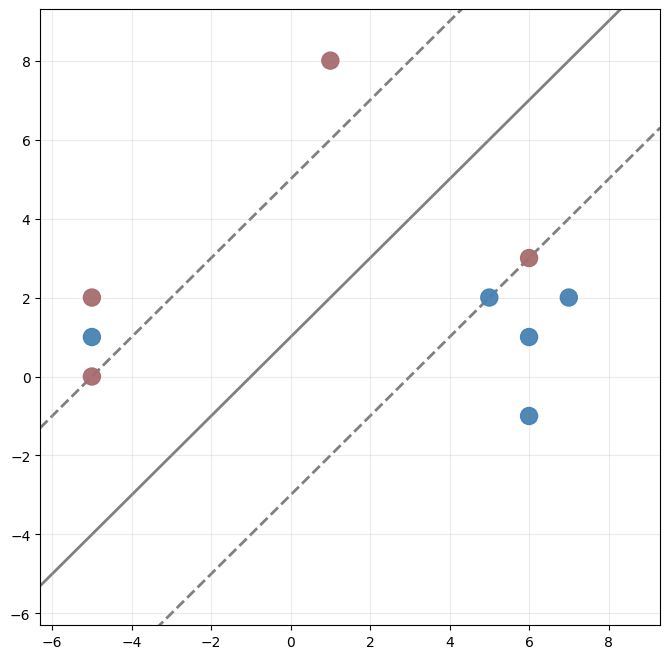

In [2]:
import numpy as np

# Data and Labels 
X = np.array([[1,8],[7,2],[6,-1],[-5,0], [-5,1], [-5,2],[6,3],[6,1],[5,2]])
y = np.array([1,-1,-1,1,-1,1,1,-1,-1])

# Support vector parameters 
w, b = np.array([-1/4, 1/4]), -1/4

# Plot the data and support vector boundaries 
linear_plot(X, y, w=w, b=b)

**Part A [5 pts]**: What is the margin of this particular SVM? 

In [3]:
margin = 4 # update margin to be a correct number

# YOUR CODE HERE

In [4]:
# tests that margin was updated correctly

**Part B [5 pts]**: Which training examples are the support vectors? Assign the coordinate in the list. e.g. support_vectors = [(1,0),(0,0)]

In [5]:
# uncomment and update support_vectors  
# YOUR CODE HERE
support_vectors=[(-5,0), (5,2), (6,3)] 

In [6]:
# tests support_vectors

Explain your answer for which training examples are support vectors. For the support vectors that you have identified, which are the in-bound support vectors and which are the out-bound support vectors? 

In [7]:
# instructor testing cell 
# YOUR CODE HERE
print('''
    The dots that are on the dashed line represent the support vectors. For in bound and out of bound:
    
    (-5,0) - Red on red line, therefore in bound
    (5,2) - Blue on blue line, therefore in bound
    (6,3) - Red on blue line, therefore out bound
    
    SVMs that are on the line of their support class, are considered to be in bound. 
    SVMs that are on the line of the other class are considered to be out of bound.
    ''')


    The dots that are on the dashed line represent the support vectors. For in bound and out of bound:
    
    (-5,0) - Red on red line, therefore in bound
    (5,2) - Blue on blue line, therefore in bound
    (6,3) - Red on blue line, therefore out bound
    
    SVMs that are on the line of their support class, are considered to be in bound. 
    SVMs that are on the line of the other class are considered to be out of bound.
    


**Part C [5 pts]**: Which training examples have nonzero slack? List their coordinates.

In [8]:
# list of coordinates with nonzero slack 
nonzero_slack=[(6,3)]
# YOUR CODE HERE

In [9]:
# tests nonzero_slack list 

How did you know which training examples had nonzero slack? 

In [10]:
# instructor testing cell
# YOUR CODE HERE
print('''
    The point (6,3) has a nonzero slack value because it is on the wrong side of the decision boundary.

    This point has been misclassified and is on the wrong side of the decision boundary implicating that it has a nonzero slack value.
    ''')


    The point (6,3) has a nonzero slack value because it is on the wrong side of the decision boundary.

    This point has been misclassified and is on the wrong side of the decision boundary implicating that it has a nonzero slack value.
    


**Part D [5 pts]**: Compute the slack $\xi_i$ associated with the misclassified points. 

In [11]:
# YOUR CODE HERE
# Define the decision boundary coefficients
w = np.array([1, -2])
b = 0

misclassified_points = np.array([[6, 3]])
labels = np.array([-1])

slacks = []
for i, point in enumerate(misclassified_points):
    y_i = labels[i]
    slack = max(0, 1 - y_i * (np.dot(w, point) + b))
    slacks.append(slack)

print(f"Computed slack values: {slacks}")

Computed slack values: [1]


In [12]:
# tests slacks

Do these slack values agree with the plot of the data and the support vector boundaries?

### Answer

Yes, the slack values make sense with what is observed of the SVM.

### Part 2: The Margin vs Slack [20 pts]
***

In this problem we'll figure out how to fit linear SVM models to data using sklearn.  Consider the data shown below.

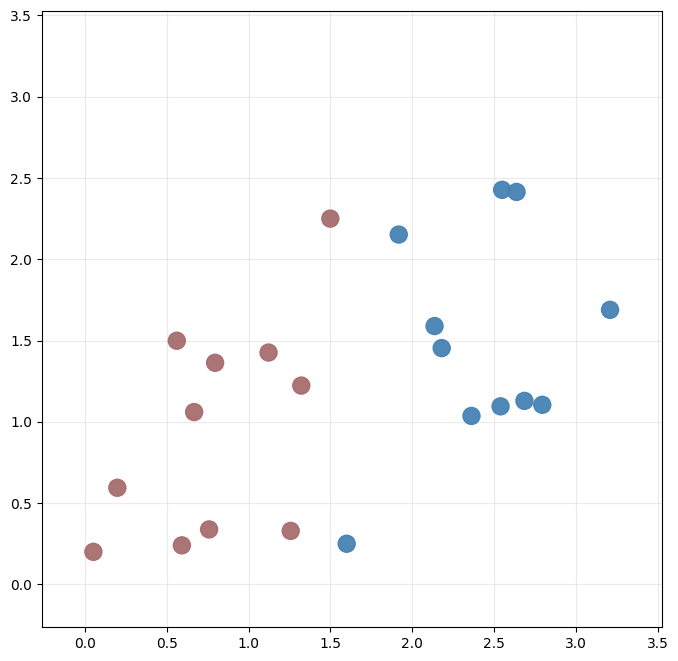

In [27]:
X, y = part2data()
linear_plot(X, y)

**Part A [5 pts]**: Let's fit a linear Soft-Margin SVM to the data above. For SVMs with a linear kernel we'll use the [`LinearSVM`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) method from sklearn's `svm` module.  Go now and look at the documentation. 

Recall that the primal objective function for the linear kernel SVM is as follows 


$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i^p.
$$
**Note that the C parameter definition in sklearn is different from the textbook.**

The two optional parameters in `LinearSVM` that we'll be most concerned with are `C`, the hyperparameter weighting the slackness contribution to the primal objective function, and `loss`, which determines the exponent on the slack variables in the sum. When $p=1$ from above equation, the loss is hinge loss, whereas is $p=2$, it's $L2$ form, the loss is called squared-hinge.

Write some code below to train a linear SVM with $C=1$ and $p=1$, get the computed weight vector and bias, and the plot the resulting model. 

[-1.41897528  0.30584252] [1.76759606]


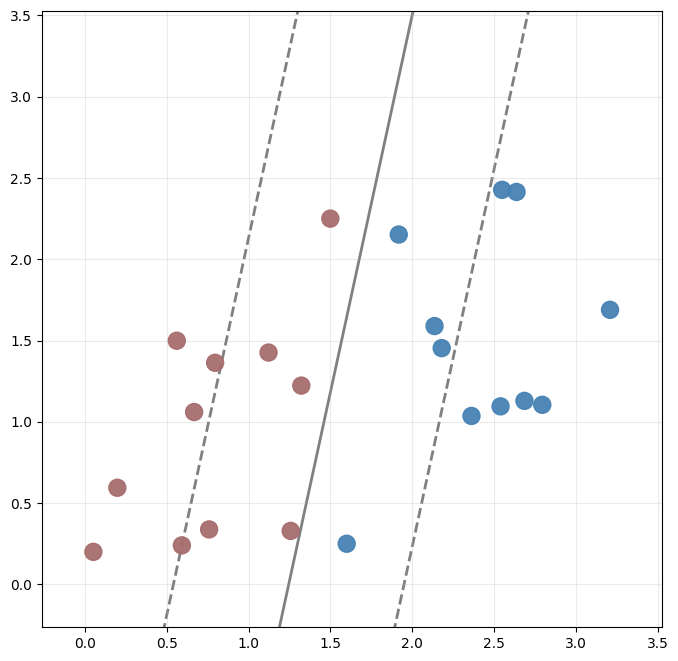

In [28]:
from sklearn.svm import LinearSVC

# TODO: Build a LinearSVC model called lsvm. Train the model and get the parameters, pay attention to the loss parameter
lsvm = LinearSVC(C=1, loss='hinge', max_iter=10000)
# YOUR CODE HERE
lsvm.fit(X, y)

# use this code to plot the resulting model
w = lsvm.coef_[0]
b = lsvm.intercept_
print(w,b)
linear_plot(X, y, w=w, b=b)

In [29]:
# tests w and b 

**Part B [5 pts]**: Experiment with different values of `C`. How does the choice of `C` affect the nature of the decision boundary and the associated margin? 

[-3.20892107  0.75511196] [4.11437969]


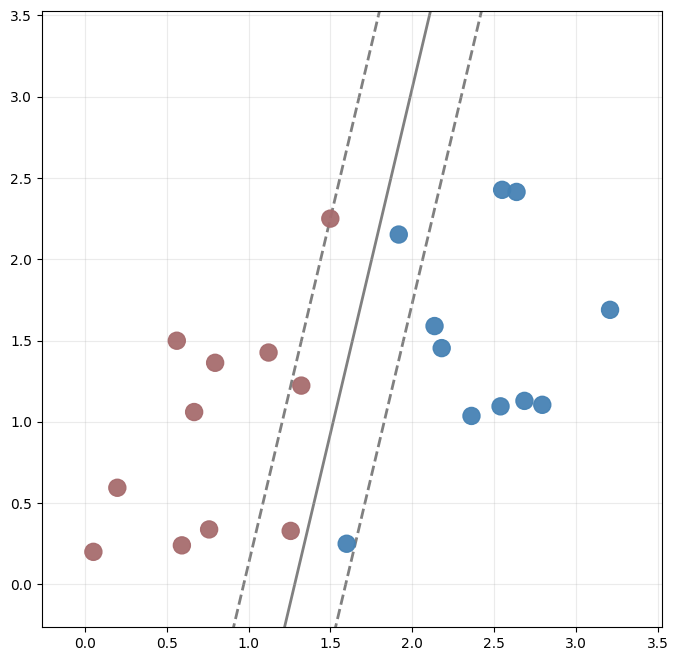

In [30]:
from sklearn.svm import LinearSVC

# TODO: Change the svm model parameter and plot the result.

lsvm = LinearSVC(C=10, loss='hinge', max_iter=10000)
# YOUR CODE HERE
lsvm.fit(X, y)

# use this code to plot the resulting model
w = lsvm.coef_[0]
b = lsvm.intercept_
print(w,b)
linear_plot(X, y, w=w, b=b)

# Observations

Looking at the plot, when the value for C is changed (particularly increased), this makes the slack less and in turn focusses on correctly classifying the points. When the value of C is decreased, the opposite happens.

**Part C [5 pts]**: Set `C=3` and compare the results you get when using the `hinge` vs the `squared_hinge` values for the `loss` parameter. Explain your observations. Compare hinge loss vs. squared hinge loss.  

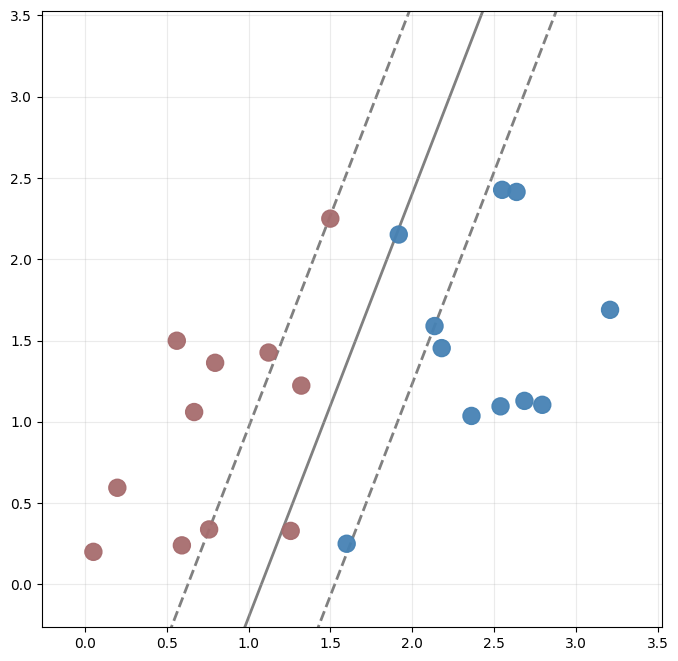

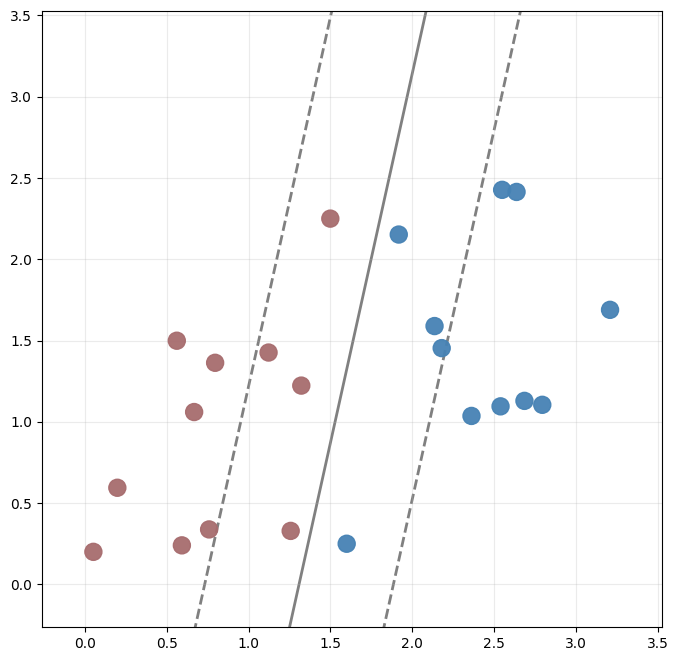

In [32]:
from sklearn.svm import LinearSVC

# TODO: Train the model and get the parameters, pay attention to the loss parameter
# YOUR CODE HERE

lvsmHinge = LinearSVC(C=3, loss='hinge', max_iter=10000)
lvsmSquare = LinearSVC(C=3, loss='squared_hinge', max_iter=10000)

lvsmHinge.fit(X,y)
lvsmSquare.fit(X,y)


# use this code to plot the resulting model
wH = lvsmHinge.coef_[0]
wS = lvsmSquare.coef_[0]
bH = lvsmHinge.intercept_
bS = lvsmSquare.intercept_

linear_plot(X,y, w=wH, b=bH)
linear_plot(X,y, w=wS, b=bS)

### Answer

The primary difference between the two types of loss parameters in `hinge` and `squared_hinge` is the width of the margin. The distribution of the support vectors (the dots) are also different between the two plots that are produced as well. The `squared_hinge` distribution has less classifications (dots on the line) in comparison to the `hinge`.

**Part D [5 pts]**: In general, how does the choice of `C` affect the bias and variance of the model? 

In [33]:
# YOUR CODE HERE

print('''
        The C value is a way to balance the trade off between maximizing the margin and minimizing the classification error. A smaller C would implicate that
        there is a wider margin with more misclassifications and thus a higher bias and lower variance. A larger C would implicate that there is a narrower
        margin with less misclassifications and thus a lesser bias but higher variance.
    ''')


        The C value is a way to balance the trade off between maximizing the margin and minimizing the classification error. A smaller C would implicate that
        there is a wider margin with more misclassifications and thus a higher bias and lower variance. A larger C would implicate that there is a narrower
        margin with less misclassifications and thus a lesser bias but higher variance.
    


### Part 3: Nonlinear SVM, Parameter Tuning, Accuracy, and Cross-Validation [25 pts]
***

Any support vector machine classifier will have at least one parameter that needs to be tuned based on the training data.  The guaranteed parameter is the $C$ associated with the slack variables in the primal objective function, i.e. 

$$
\min_{{\bf w}, b, {\bf \xi}} \frac{1}{2}\|{\bf w}\|^2 + C \sum_{i=1}^m \xi_i
$$

If you use a kernel fancier than the linear kernel then you will likely have other parameters as well. For instance in the polynomial kernel $K({\bf x}, {\bf z}) = ({\bf x}^T{\bf z} + c)^d$ you have to select the shift $c$ and the polynomial degree $d$.  Similarly the rbf kernel

$$
K({\bf x}, {\bf z}) = \exp\left[-\gamma\|{\bf x} - {\bf z}\|^2\right]
$$

has one tuning parameter, namely $\gamma$, which controls how fast the similarity measure drops off with distance between ${\bf x}$ and ${\bf z}$. 

For our examples we'll consider the rbf kernel, which gives us two parameters to tune, namely $C$ and $\gamma$. 

Consider the following two dimensional data

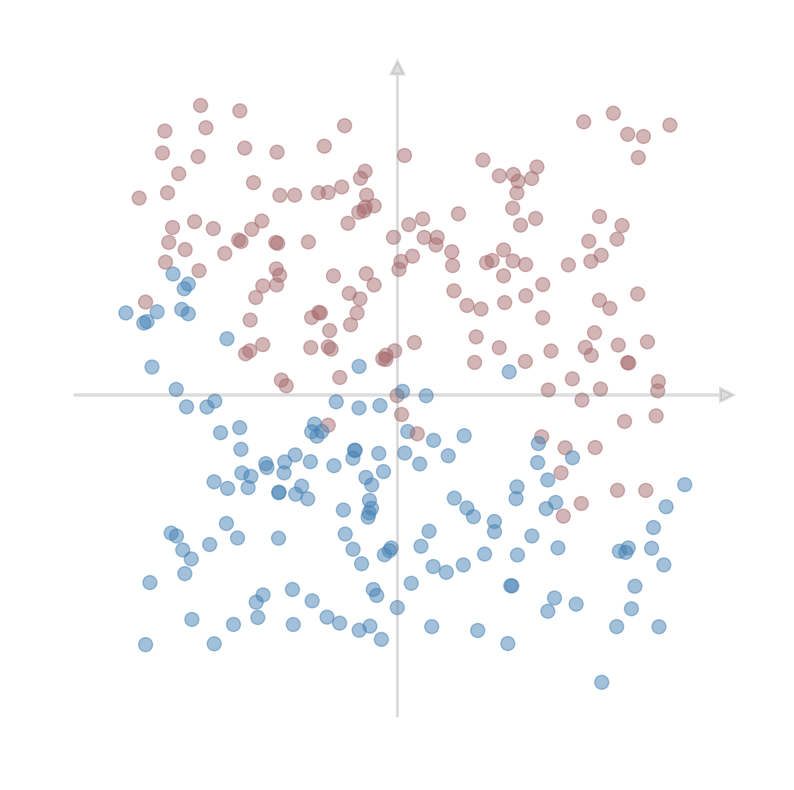

In [34]:
X, y = part3data(N=300, seed=1235)
nonlinear_plot(X, y)

**Part A [5 pts]**: We can use the method [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from sklearn's `svm` module to fit an SVM with a nonlinear kernel to the data.  Go now and look at the documentation. Note that we pass the `kernel="rbr"` parameter to use the RBF kernel.  The other two parameters we'll be concerned with are `C` and the RBF parameter `gamma`.   

Write some code to fit an SVM with RBF kernel to the data and plot the results.  Use the parameter values `C=1` and `gamma=1`.

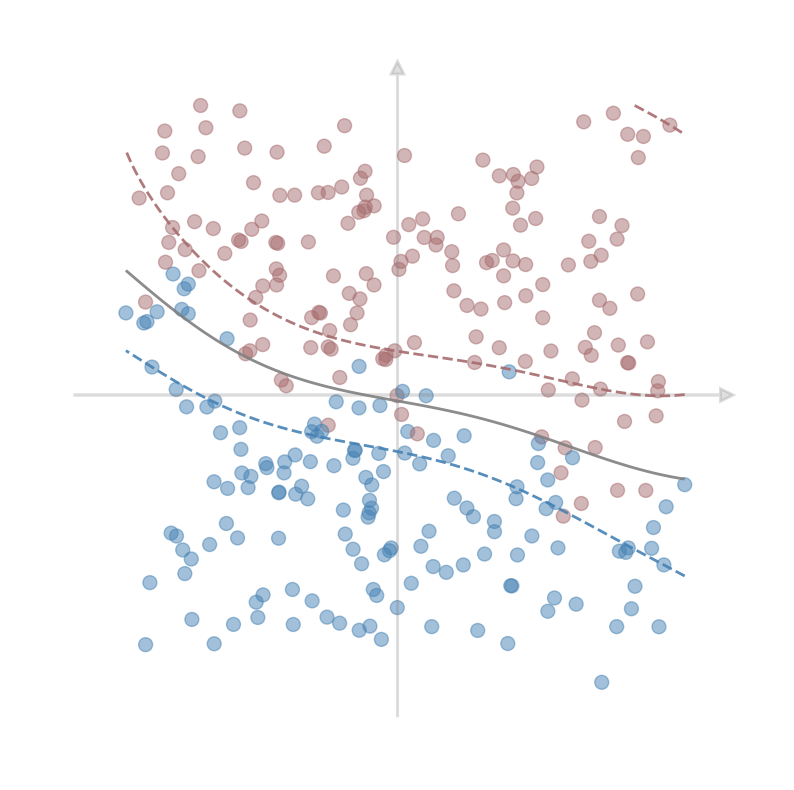

In [35]:
from sklearn.svm import SVC

nlsvm = SVC(kernel='rbf', C=1, gamma=1)
# YOUR CODE HERE
nlsvm.fit(X,y)
nonlinear_plot(X, y, nlsvm)

**Part B [15 pts]**: In this part we'll use cross-validation to estimate the validation accuracy achieved by our model.  Experiment with the values of the hyperparameters to see if you can get a good validation accuracy. How do the choice of `C` and `gamma` affect the resulting decision boundary? 

cross-val mean-accuracy: 0.920
C=0.01, Cross-validation mean accuracy: 0.527
C=0.1, Cross-validation mean accuracy: 0.903
C=1, Cross-validation mean accuracy: 0.920
C=10, Cross-validation mean accuracy: 0.933
C=100, Cross-validation mean accuracy: 0.940
Best C value: 100 with mean accuracy: 0.940
Gamma=0.01, Cross-validation mean accuracy: 0.913
Gamma=0.1, Cross-validation mean accuracy: 0.920
Gamma=1, Cross-validation mean accuracy: 0.940
Gamma=10, Cross-validation mean accuracy: 0.920
Gamma=100, Cross-validation mean accuracy: 0.913
Best Gamma value: 1 with mean accuracy: 0.940


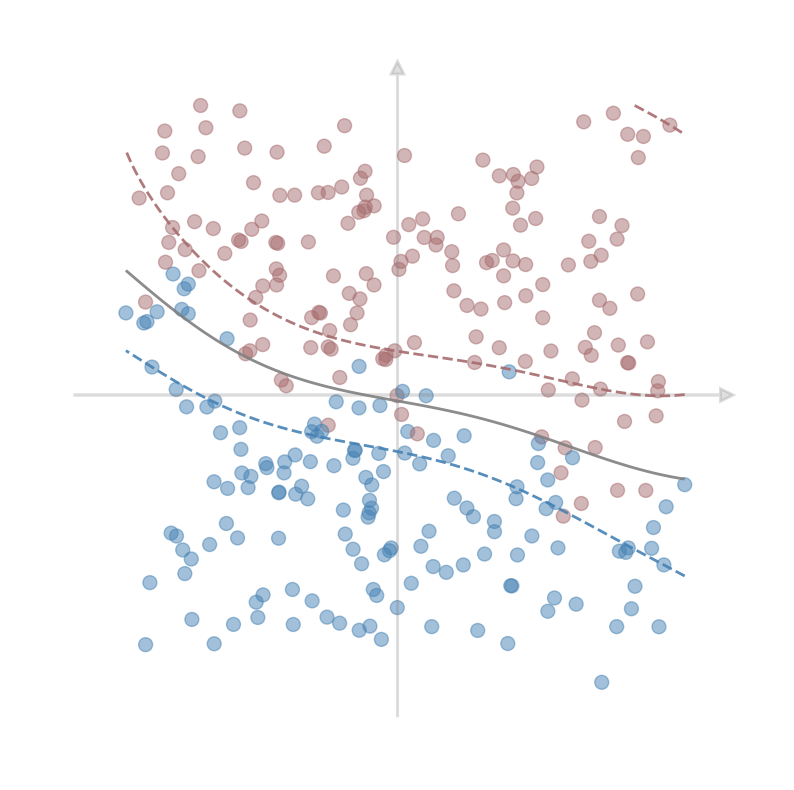

In [37]:
from sklearn.model_selection import cross_val_score

# YOUR CODE HERE
nlsvm = SVC(kernel='rbf', C=1, gamma=1)
scores = cross_val_score(nlsvm, X, y, cv=5)
print("cross-val mean-accuracy: {:.3f}".format(np.mean(scores)))
nlsvm.fit(X,y)
nonlinear_plot(X, y, nlsvm)

# C tuning
# YOUR CODE HERE

best_score_C = 0
best_C = None
for C in [0.01, 0.1, 1, 10, 100]:
    temp_model = SVC(kernel='rbf', C=C, gamma=1)
    temp_scores = cross_val_score(temp_model, X, y, cv=5)
    mean_score = np.mean(temp_scores)
    print(f"C={C}, Cross-validation mean accuracy: {mean_score:.3f}")
    if mean_score > best_score_C:
        best_score_C = mean_score
        best_C = C

print(f"Best C value: {best_C} with mean accuracy: {best_score_C:.3f}")

# gamma tuning
# YOUR CODE HERE

best_score_gamma = 0
best_gamma = None
for gamma in [0.01, 0.1, 1, 10, 100]:
    temp_model = SVC(kernel='rbf', C=best_C, gamma=gamma)
    temp_scores = cross_val_score(temp_model, X, y, cv=5)
    mean_score = np.mean(temp_scores)
    print(f"Gamma={gamma}, Cross-validation mean accuracy: {mean_score:.3f}")
    if mean_score > best_score_gamma:
        best_score_gamma = mean_score
        best_gamma = gamma

print(f"Best Gamma value: {best_gamma} with mean accuracy: {best_score_gamma:.3f}")

**Part C [5 pts]**: How does the choice of **kernel** function affect the bias/variance of the model?

In [38]:
# instructor testing cell 
# YOUR CODE HERE

print('''
        No matter the kernel that is selected, the choice of kernel is going to change the bias and variance of one model compared to another with a different
        kernel. For example, linear kernels tend to have a high bias because of the strong assumption that is imposed upon it.
    ''')


        No matter the kernel that is selected, the choice of kernel is going to change the bias and variance of one model compared to another with a different
        kernel. For example, linear kernels tend to have a high bias because of the strong assumption that is imposed upon it.
    


### Part 4: Automating the Parameter Search [20 pts]
***

On the previous problem we were able to choose some OK parameters just by hand-tuning.  But in real life (where time is money) it would be better to do something a little more automated.  One common thing to do is a **grid-search** over a predefined range of the parameters.  In this case you will loop over all possible combinations of parameters, estimate the accuracy of your model using K-Folds cross-validation, and then choose the parameter combination that produces the highest validation accuracy. 

**Part A [5 pts]**: Below is an experiment where we search over a logarithmic range between $2^{-5}$ and $2^{5}$ for $C$ and a range between $2^{-5}$ and $2^{5}$ for $\gamma$.  For the accuracy measure we use K-Folds CV with $K=3$.

In [41]:
from sklearn.model_selection import cross_val_score, GridSearchCV

svc = SVC()

param_grid = {
    'C': [2**i for i in range(-5, 6)],   
    'gamma': [2**i for i in range(-5, 6)]
}

grid = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy')

grid.fit(X, y)

print("Best Parameters:", grid.best_params_)
print("Best Cross-Validation Accuracy: {:.3f}".format(grid.best_score_))


Best Parameters: {'C': 8, 'gamma': 8}
Best Cross-Validation Accuracy: 0.943


**Part B [5 pts]**: The following function will plot a heat-map of the cross-validation accuracies for each combination of parameters.  Which combination looks the best? 

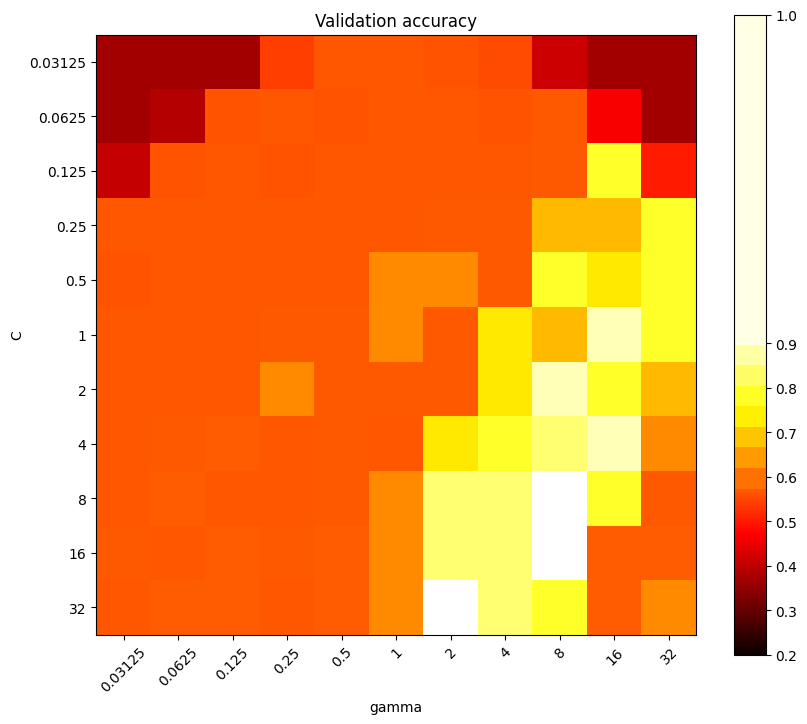

In [42]:
plotSearchGrid(grid)

### Answer

The combination that appears to have the highest validation accuracy is when C and gamma equal 8.

In [44]:
# instuctor testing cell 
# YOUR CODE HERE

**Part C [5 pts]**: The GridSearchCV object scores, among other things, the best combination of parameters as well as the cross-validation accuracy achieved with those parameters.  Print those quantities for our model. 

In [45]:
# print best parameters and best accuracy 
# YOUR CODE HERE
print("Best Parameters: {}".format(grid.best_params_))
print("Best Cross-Validation Accuracy: {:.3f}".format(grid.best_score_))

Best Parameters: {'C': 8, 'gamma': 8}
Best Cross-Validation Accuracy: 0.943


**Part D [5 pts]**: The GridSearchCV object also stores the classifier trained with the best hyperparameters.  Pass this best estimator into the `nonlinear_plot` function to view the best decision boundary. What can you tell about the best decision boundary? 

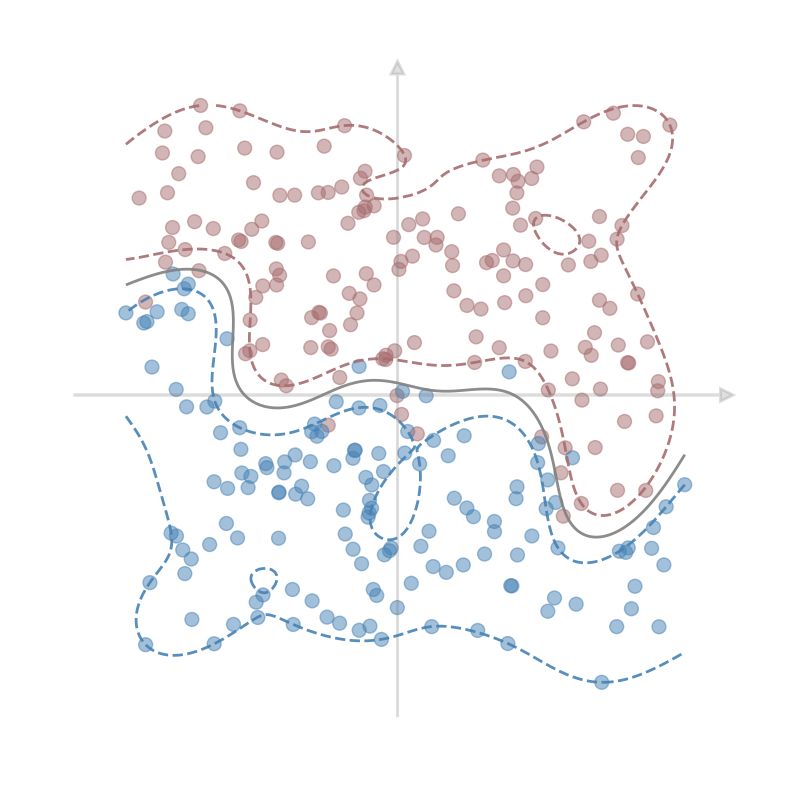

In [46]:
# pass GridSearchCV object best estimator into nonlinear_plot
# YOUR CODE HERE

best_model = grid.best_estimator_

nonlinear_plot(X, y, best_model)

### Answer

We can see from the nature of the decision boundary that the model has high variance and low bias. This is because the decision boundary is very complex and is not a straight line. The curvy nature of this line implicates that the model is potentially over fitting the data. 